In [1]:
# some packages are not needed but these are what I usually use
# i wasn't able to filter which ones are not needed
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature import NaturalEarthFeature, COLORS
from matplotlib.patches import Polygon
from matplotlib.colors import from_levels_and_colors
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as pe
from mpl_toolkits.basemap import Basemap, maskoceans
import matplotlib.ticker as plticker
import matplotlib.patches as patches
from matplotlib import ticker
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

mpl.rcParams['figure.dpi'] = 300


In [2]:
exp='FLAT3_v1' # kindly refer to your file directory (f variable line here)
folder = 'v1'

# indicate the min and max lat lon of the area where you want to flatten
latstart1 = 6
latend1 = 8
lonstart1 = 124
lonend1 = 126

proj=crs.PlateCarree()

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
          'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
           cmap(np.linspace(minval, maxval, n)))
    return new_cmap   


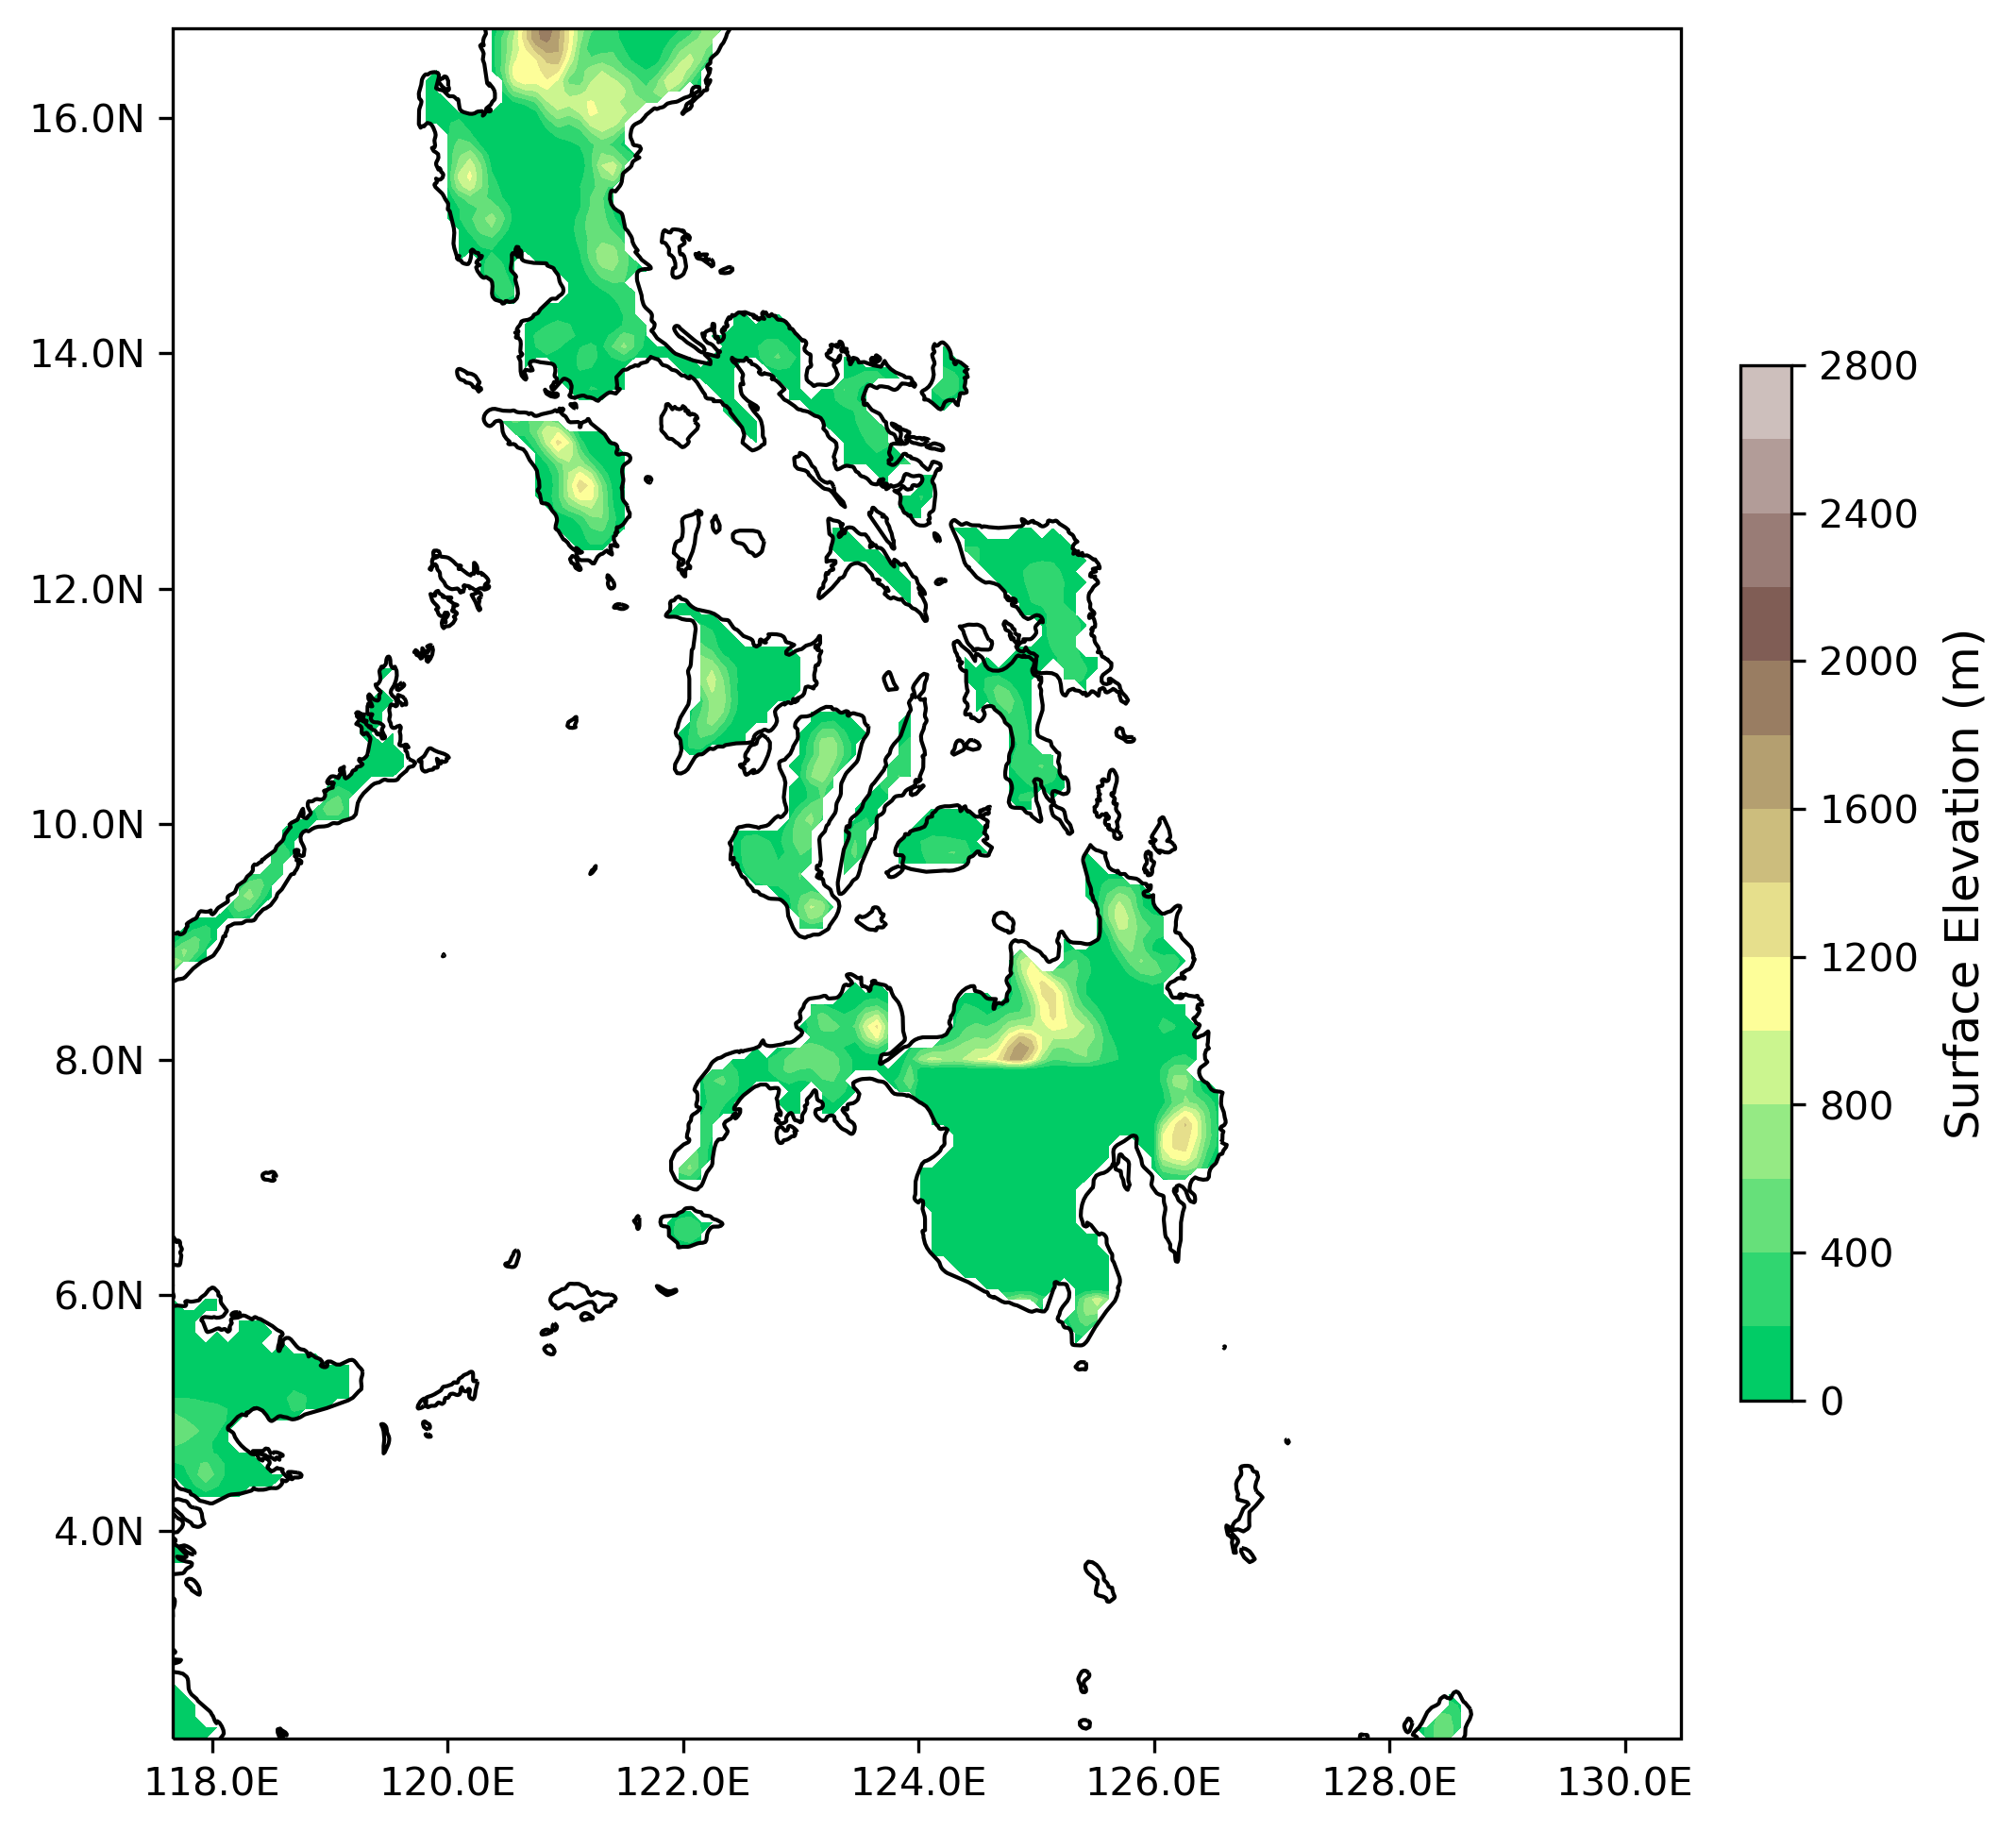

In [3]:
# if you want to change your terrain on each domain, you have to perform this process
# on each geo_em file (e.g., geo_em.d01, geo_em.d02)
f = Dataset('/mnt/reiwa/cathrene/pre_proc/proc_terrain/APR2022/'+ folder +'/geo_em.d02_'+ exp +'.nc', mode='r+')

xlat = f.variables['XLAT_M'][:]
xlon = f.variables['XLONG_M'][:]
hgt = f.variables['HGT_M'][:]
e_we = len(f.dimensions['west_east'])
e_sn = len(f.dimensions['south_north'])

for j in range(e_sn):
        for i in range(e_we):
                if xlat[0,j,i] >= latstart1 and xlat[0,j,i] <= latend1 and \
                   xlon[0,j,i] >= lonstart1 and xlon[0,j,i] <= lonend1:
                        hgt[0,j,i] = 10 # flatten to 10-m !!!


f.variables['HGT_M'][:] = hgt # important line to directly replace values on your geo_em file

fig, ax = plt.subplots(figsize=(10, 8))
gs = gridspec.GridSpec(nrows=1, ncols=1)
    
ax = plt.subplot(gs[0,0], projection=proj)
lons = xlon[0,:]
lats = xlat[0,:]
topog = hgt[0,:]
cmap = plt.get_cmap('terrain')
new_cmap = truncate_colormap(cmap, 0.25, 0.9)

nc_new = maskoceans(lons,lats,topog)
vmin=0
vmax=2800
v = np.linspace(vmin, vmax, 15, endpoint=True)
norm = mpl.colors.BoundaryNorm(v, new_cmap.N)

a = ax.contourf(lons, lats, nc_new, v, cmap=new_cmap, norm=norm, vmin=vmin, vmax=vmax)
ax.add_feature(coast, edgecolor='black', alpha=1)
lon_formatter = LongitudeFormatter(number_format='.1f',
                                   degree_symbol='',
                                   dateline_direction_label=True,
                                   zero_direction_label=True) # Add to include N-E labels in ticks
lat_formatter = LatitudeFormatter(number_format='.1f',
                                   degree_symbol='')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
loc = plticker.MultipleLocator(base=2) 
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)

cax = fig.add_axes([.8, 0.2742, 0.018, 0.457]) # l, b, w, h
cb = fig.colorbar(a, cax=cax)
cb.set_label('Surface Elevation (m)', size=12, labelpad=6)
